# CS 505 Homework 04:  Classification

#### Due Friday  10/27 at midnight (1 minute after 11:59 pm) in Gradescope (with a grace period of 6 hours)
#### You may submit the homework up to 24 hours late (with the same grace period) for a penalty of 10%. 

All homeworks will be scored with a maximum of 100 points; point values are given
for individual problems, and if parts of problems do not have point values given, they
will be counted equally toward the total for that problem. 

Note: I strongly recommend you work in **Google Colab** (the free version) to complete homeworks in this class; in addition to (probably) being faster than your laptop, all the necessary libraries will already be available to you, and you don't have to hassle with <code>conda</code>, <code>pip</code>, etc. and resolving problems when the install doesn't work. But it is up to you!   You should go through the necessary tutorials listed on the web site concerning Colab and storing files on a Google Drive. And of course, Dr. Google is always ready to help you resolve your problems. 

I will post a  "walk-through" video ASAP on my <a href="https://www.youtube.com/channel/UCfSqNB0yh99yuG4p4nzjPOA">Youtube Channel</a>. 

#### Submission Instructions

You must complete the homework by editing <b>this notebook</b> and submitting the following two files in Gradescope by the due date and time:

  - A file <code>HW04.ipynb</code> (be sure to select <code>Kernel -> Restart and Run All</code> before you submit, to make sure everything works); and
  - A file <code>HW04.pdf</code> created from the previous.
  
  For best results obtaining a clean PDF file on the Mac, select <code>File -> Print Review</code> from the Jupyter window, then choose <code>File-> Print</code> in your browser and then <code>Save as PDF</code>.  Something  similar should be possible on a Windows machine -- just make sure it is readable and no cell contents have been cut off. Make it easy to grade!
  
The date and time of your submission is the last file you submitted, so if your IPYNB file is submitted on time, but your PDF is late, then your submission is late. 

## Collaborators (5 pts)

Describe briefly but precisely

1. Any persons you discussed this homework with and the nature of the discussion;
2. Any onl1resources you consulted and what information you got from those resources; and
3. Any AI agents (such as chatGPT or CoPilot) or other applications you used to complete the homework, and the nature of the help you received. 

A few brief sentences is all that I am looking for here. 

#1 to know more about the plays(curisoity) : https://www.shakespeare.org.uk/explore-shakespeare/shakespedia/shakespeares-plays/ 

#2 diving and understanding document term matrix  also had an inssue : https://medium.com/analytics-vidhya/tdm-term-document-matrix-and-dtm-document-term-matrix-8b07c58957e2 || https://math.stackexchange.com/questions/304707/term-document-vs-document-term-matrix

#3 i was having additional queries and previously also reffered this website on Word2Vec : https://www.coveo.com/blog/word2vec-explained/

#4 i was having issue with 1E where i was not correctly unpacking the elments and giving worng inputs . so took help from GPT to solve this . also few debuing in Part 2 (in terms of understanding). got to know about AdamW optimzer : ChatGPT



In [1]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

from torchvision.datasets import MNIST
import torchvision.transforms as T

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer




/Users/mohanthota/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


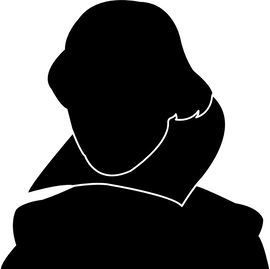

## Problem One: Exploring Shakespeare's Plays with PCA (45 pts)

In this problem, we will use Principal Components Analysis to look at Shakespeare's plays, as
we discussed with a very different play/movie in lecture.  Along the way, we shall use the tokenizer and the TF-IDF vectorizer from `sklearn,`
a common machine learning library.

Note: There is a library for text analysis in Pytorch called `Torchtext`, however, in my view this will less well-developed and less well-supported than the rest of Pytorch, so we shall use `sklearn` for this problem. 

 

### Part A:  Reading and exploring the data (5 pts)

The cells below read in three files and convert them to `numpy` arrays (I prefer to work with the arrays rather than with `pandas` functions, but it is your choice).  

1. The file `shakespeare_plays.csv` contains lines from William Shakespeare’s plays. The second column of the file contains the name of
the play, the third the name of the player (or the indication `<Stage Direction>`, and the fourth
the l1spoken: 

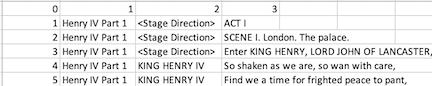


2. The file `play_attributes.csv` stores the genres and chronology of Shakepeare's plays; the first column is the name of the play, the second the genre, and the third its order in a chronological listing of when it was first performed. The plays are in the same (arbitrary) order as in the first file. 


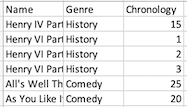


3. The file `player_genders.csv` stores the name of a major character (defined somewhat arbitrarily as one whose total lines contain more than 1400 characters) in the first column and their gender in the second. 



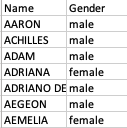

**To Do:**   For each of the arrays, print out the the `shape` and the first line. 


In [2]:
plays_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/shakespeare_plays.csv').to_numpy()

player_genders_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/player_genders.csv').to_numpy()

play_attributes_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/play_attributes.csv').to_numpy()



import pandas as pd
import numpy as np

print("Plays Array:")
print("Shape:", plays_array.shape)
print("First Line:", plays_array[0])

print("\nPlayer Genders Array:");print("Shape:", player_genders_array.shape)
print("First Line:", player_genders_array[0]);print("\nPlay Attributes Array:")
print("Shape:", play_attributes_array.shape)
print("First Line:", play_attributes_array[0])



Plays Array:
Shape: (111582, 4)
First Line: [1 'Henry IV Part 1' '<Stage Direction>' 'ACT I']

Player Genders Array:
Shape: (398, 2)
First Line: ['AARON' 'male']

Play Attributes Array:
Shape: (36, 3)
First Line: ['Henry IV Part 1' 'History' 15]


### Part B: Visualizing the Plays (8 pts)

1. Create an array containing 36 strings, each being the concatenation of all lines spoken.   Be sure to NOT include stage directions!  You may wish to create an appropriate dictionary as an intermediate step. 

2. Create a document-term matrix where each row represents a play and each column represents a term used in that play. Each entry in this matrix represents the number of times a particular word (defined by the column) occurs in a particular play (defined by the row). Use `CountVectorizer` in `sklearn` to create the matrix. Keep the rows in the same order as in the original files in order to associate play names with terms correctly. 

3. From this matrix, use `TruncatedSVD` in `sklearn` to create a 2-dimensional representation of each play. Try to make it as similar as possible to the illustration below, including (i) appropriate title, (ii) names of each play, followed by its chronological order, and (iii) different colors for each genre. Use a `figsize` of `(8,8)` and a `fontsize` of `6` to provide the best visibility. You can follow the tutorial [here](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/) to create the visualization (look at the "PCA" part).

4. Now do the same thing all over again, but with TF-IDF counts (using `TFIDFVectorizer` in `sklearn`). 


5. Answer the following in a few sentences:  What plays are similar to each other? Do they match the grouping of Shakespeare’s plays into comedies, histories, and tragedies here?  Which plays are outliers (separated from the others in the same genre)?  Did one of TF or TF-IDF provided the best insights?


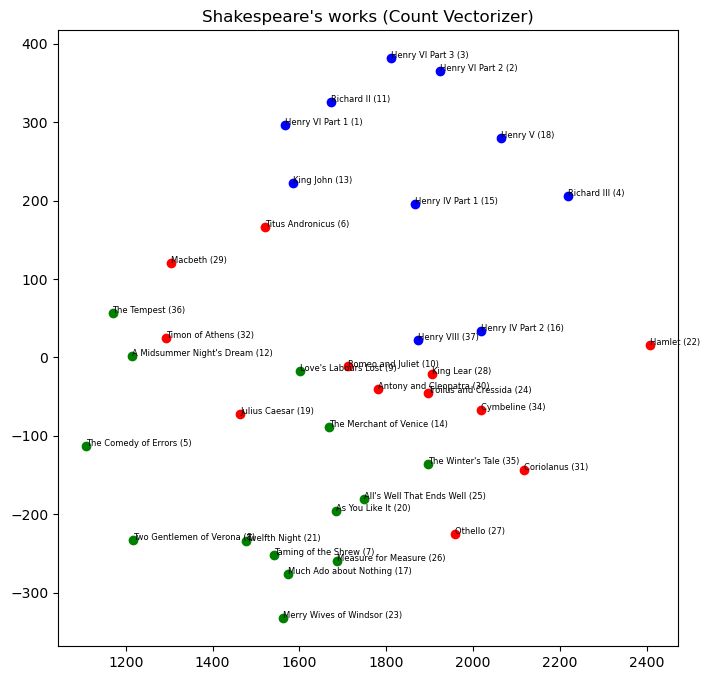

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
aggregated_plays = {}
for entry in plays_array:
    play, actor, text = entry[1], entry[2], entry[3]
    if actor != "<Stage Direction>":
        aggregated_plays[play] = aggregated_plays.get(play, "") + " " + text

plays_text = list(aggregated_plays.values())

X_vec = CountVectorizer().fit_transform(plays_text);X_reduced = TruncatedSVD(n_components=2).fit_transform(X_vec)
genres_list = play_attributes_array[:, 1]
order_list = play_attributes_array[:, 2]
plt.figure(figsize=(8, 8))
colors = {"Comedy": "green", "Tragedy": "red", "History": "blue"}
for idx, (a, b) in enumerate(X_reduced):
    plt.scatter(a, b, color=colors[genres_list[idx]])
    plt.annotate(f"{play_attributes_array[idx, 0]} ({order_list[idx]})", (a, b), fontsize=6)

plt.title("Shakespeare's works (Count Vectorizer)")
plt.show()


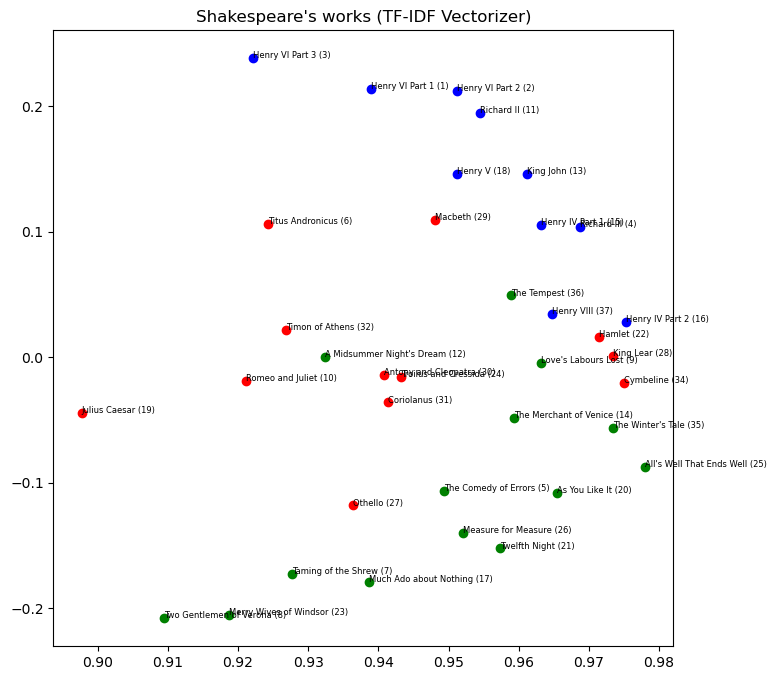

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

tfidf_vec = TfidfVectorizer();X_tfidf_transformed = tfidf_vec.fit_transform(plays_text)
svd = TruncatedSVD(n_components=2);X_reduced_tfidf = svd.fit_transform(X_tfidf_transformed)
plt.figure(figsize=(8, 8))
for idx, (a, b) in enumerate(X_reduced_tfidf):
    plt.scatter(a, b, color=colors[genres_list[idx]])
    plt.annotate(f"{play_attributes_array[idx, 0]} ({order_list[idx]})", (a, b), fontsize=6)

plt.title("Shakespeare's works (TF-IDF Vectorizer)")
plt.show()


Observations

1. **Similar Plays**:
From tf-idf, "Henry VI Part 3", "Henry VI Part 2", and "Henry VI Part 1" are close to each other. Similarly, "The Tempest", "King Henry VIII", "Hamlet", and "King Lear" .
From counter Vectorizer, "Titus Andronicus", "Macbeth", and "The Tempest" are close, while "Romeo and Juliet", "King Lear", and "Hamlet" also cluster together. hmm interesting.... made me retink for a second .

2. **Match with Shakespeare's Groupings**:
the genres are collided in counter vectorizer . in TF IDF it have not done best job but compared to first graph it have observed the genres .
3. **Outliers**:
    In the TF-IDF representation, "Two Gentlemen of Verona", "Taming of the Shrew", and "Much Ado about Nothing" appear to be outliers in the comedy genre, while "Julius Caesar" is an outlier for the tragedies.
 from Count Vectorizer , "Two Gentlemen of Verona" remains an outlier for the comedies, and plays like "The Comedy of Errors" and "Merry Wives of Windsor" also appear distant from others in their respective genres. i did some background check on these with curosity .

4. **TF vs TF-IDF**:
  TF-IDF did a better job because the grouping was better than the first graph in terms of close clustering


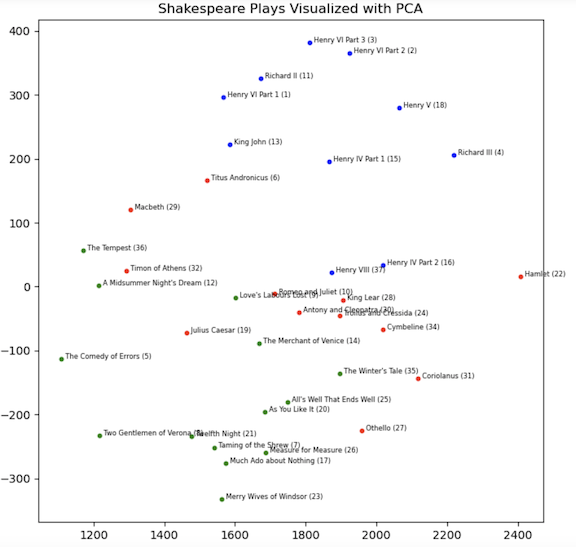

### Part C: Visualizing the Players (8 pts)

Now you must repeat this same kind of visualization, but instead of visualizing plays, you must visualize players.
The process will be essentially the same, starting with an array of strings representing the lines spoken by each player. Use one of TF or TF-IDF, and use different colors for the genders. 

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible. 

Again, comment on what you observe (it will not be as satisfying as the previous part). 

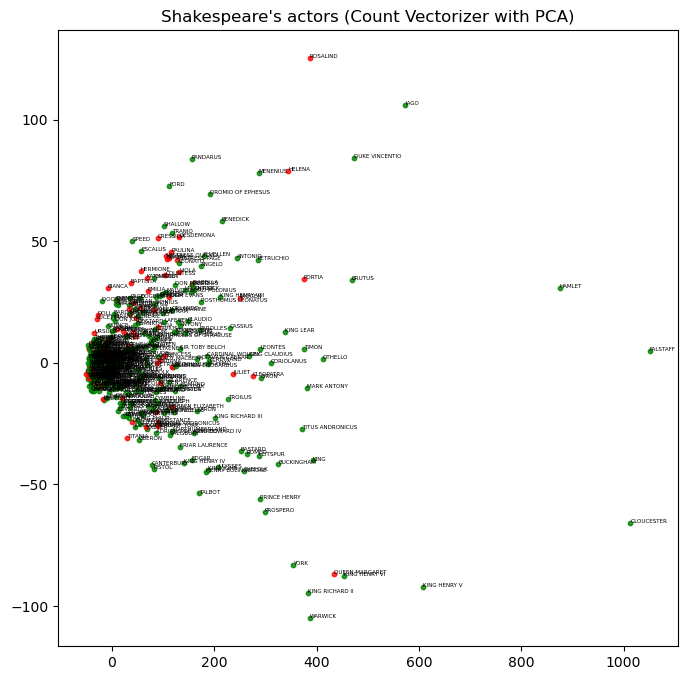

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

player_lines = {}
for entry in plays_array:
    play, actor, text = entry[1], entry[2], entry[3]
    if actor != "<Stage Direction>":
        player_lines[actor] = player_lines.get(actor, "") + " " + text

lines_by_actor = list(player_lines.values())

X_vectorized = CountVectorizer().fit_transform(lines_by_actor)
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_vectorized.toarray())
actor_genders = [dict(player_genders_array).get(actor, "Unknown") for actor in player_lines.keys()]

plt.figure(figsize=(8, 8))
colors = {"male": "green", "female": "red"}

for idx, (a, b) in enumerate(X_pca):
    actor_gender = actor_genders[idx]
    if actor_gender != "Unknown":
        plt.scatter(a, b, color=colors[actor_gender], alpha=0.8, s=10)
        plt.annotate(list(player_lines.keys())[idx], (a, b), fontsize=4, alpha=1)

plt.title("Shakespeare's actors (Count Vectorizer with PCA)")
plt.show()


Observations 

i see that , may be, that most charectors have used similar words and yes precisely short sentences . talking about outliers some of them are main charectors as per my knowledge so they might be distinct from normal charectors . again interesting to see the dense cluster 

### Part D:  DIY Word Embeddings (8 pts)

In this part you will create a word-word matrix where each row (and each column) represents a word in the vocabulary.
Each entry in this matrix represents the number of times a particular word (defined by the row) co-occurs with another
word (defined by the column) in a sentence (i.e., l1in `plays`). Using the row word vectors, create a document-term matrix which represents
a play as the average of all the word vectors in the play. 

Display the plays using `TruncatedSVD` as you did previously.  Use one of TF or TF-IDF. 

Again, comment on what you observe: how different is this from the first visualization?

**Notes:**  

1. Remove punctuation marks .  ,  ;  :  ?  ! but leave single quotes. 
2. One way to proceed is to create a nested dictionary mapping each word to a dictionary of the frequency of words that occur in the same line, then from this to create the sparse matrix which is used to create the aerage document-term matrix which is input to `TruncatedSVD`. 
3. If you have trouble with the amount of memory necessary, you may wish to eliminate "stop words" and then isolate some number (say, 5000) of the remaining most common words, and build your visualization on that instead of the complete vocabulary. 


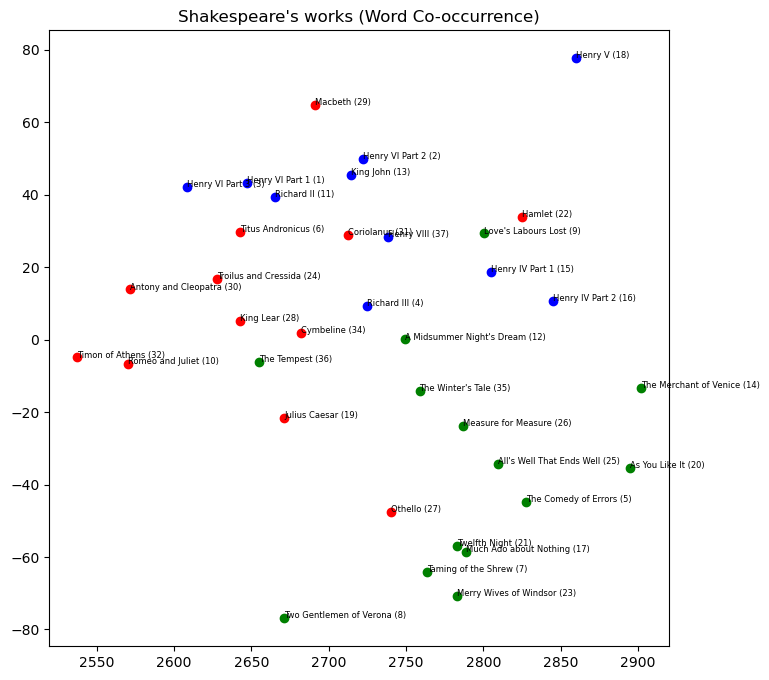

In [6]:
import numpy as np
import re
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix
def clean_line(line):
    return re.sub(r'[.,;:?!]', '', line).lower().split()

plays_to_lines = defaultdict(list)
for entry in plays_array:
    play, text = entry[1], entry[3]
    if text != "<Stage Direction>":
        plays_to_lines[play].append(clean_line(text))
word_count = Counter(word for play_lines in plays_to_lines.values() for line in play_lines for word in line);dictionary = {word: idx for idx, (word, _) in enumerate(word_count.most_common(5000))}

word_cooccurrence = defaultdict(Counter)
for play_lines in plays_to_lines.values():
    for line in play_lines:
        unique_words = set(word for word in line if word in dictionary)
        for word in unique_words:
            word_cooccurrence[word].update(unique_words)

i_vals, j_vals, freqs = [], [], []
for word, related_words in word_cooccurrence.items():
    for related, frequency in related_words.items():
        if word != related:
            i_vals.append(dictionary[word])
            j_vals.append(dictionary[related])
            freqs.append(frequency)

matrix = csr_matrix((freqs, (i_vals, j_vals)), shape=(len(dictionary), len(dictionary)));genres = play_attributes_array[:, 1];play_order = play_attributes_array[:, 2]


play_representations = []
for play, play_lines in plays_to_lines.items():
    play_vec = np.zeros(len(dictionary))
    total_words = 0
    for line in play_lines:
        for word in line:
            if word in dictionary:
                play_vec += matrix[dictionary[word]].toarray()[0]
                total_words += 1
    if total_words:
        play_vec /= total_words
    play_representations.append(play_vec)

final_matrix = np.vstack(play_representations)
X_2d_representation = svd.fit_transform(final_matrix)
color_map = {"Comedy": "green", "Tragedy": "red", "History": "blue"}

plt.figure(figsize=(8, 8))
for idx, (a, b) in enumerate(X_2d_representation):
    plt.scatter(a, b, color=color_map[genres[idx]])
    plt.annotate(f"{play_attributes_array[idx, 0]} ({play_order[idx]})", (a, b), fontsize=6)

plt.title("Shakespeare's works (Word Co-occurrence)")
plt.show()


Observations

this visualization gives us  different perspective Compared to the first visualization . think that it is giving us more infromation than the first one becuase this is based on word co occurances rather than just counting words

### Part E:  Visualizing the Plays using Word2Vec Word Embeddings (8 pts)

Now we will do the play visualization using word embeddings created by Gensim's `Word2Vec`, which can create word embeddings just as you did in the previous part, but using better algorithms. 

You can read about how to use `Word2Vec` and get template code here:

https://radimrehurek.com/gensim/models/word2vec.html

I strongly recommend you follow the directions for creating the model, then using `KeyedVectors` to
avoid recomputing the model each time. 

Experiment with the `window` (say 5) and the `min_count` (try in the range 1 - 5) parameters to get the best results. 

Display the plays using `PCA` instead of `TruncatedSVD`.  Use one of TF or TF-IDF. 

Again, comment on what you observe: how different is this from the other visualizations?


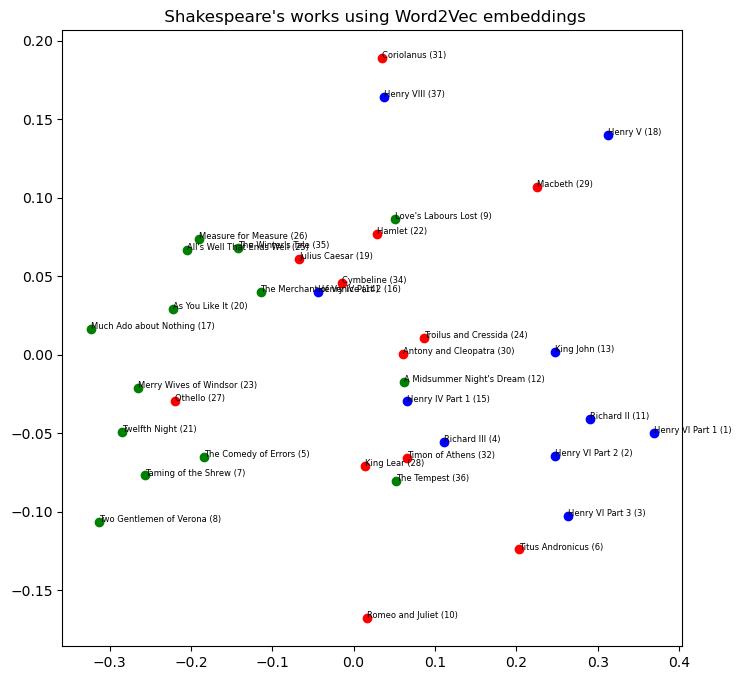

In [7]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

text_data = [sentence for sentences in plays_to_lines.values() for sentence in sentences]

w2v_model = Word2Vec(sentences=text_data, window=5, min_count=3, workers=4)
w2v_model.save("word2vec_embedding.model")

word_embeds = w2v_model.wv

avg_play_vectors = []
for play, sentences in plays_to_lines.items():
    vector_sum = np.zeros(w2v_model.vector_size)
    total_words = 0
    for sentence in sentences:
        for word in sentence:
            if word in word_embeds:
                vector_sum += word_embeds[word]
                total_words += 1
    if total_words:
        vector_sum /= total_words
    avg_play_vectors.append(vector_sum)

combined_play_vectors = np.vstack(avg_play_vectors);reduced_vectors = PCA(n_components=2).fit_transform(combined_play_vectors)

plt.figure(figsize=(8, 8))
for idx, (a, b) in enumerate(reduced_vectors):
    plt.scatter(a, b, color=color_map[genres[idx]])
    plt.annotate(f"{play_attributes_array[idx, 0]} ({play_order[idx]})", (a, b), fontsize=6)

plt.title(" Shakespeare's works using Word2Vec embeddings")
plt.show()


Observations

it shows how closely related the plays are in terms of themes and meanings. Unlike earlier visuals, it is giving us based on the overall message of the plays rather than just the words used.|


### Part F:  Visualizing the Players using Word2Vec Word Embeddings (8 pts)

Now you must repeat Part C, but using these `Word2Vec` embeddings. 

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible. 

Again, comment on what you observe. How is this different from what you saw in Part C?


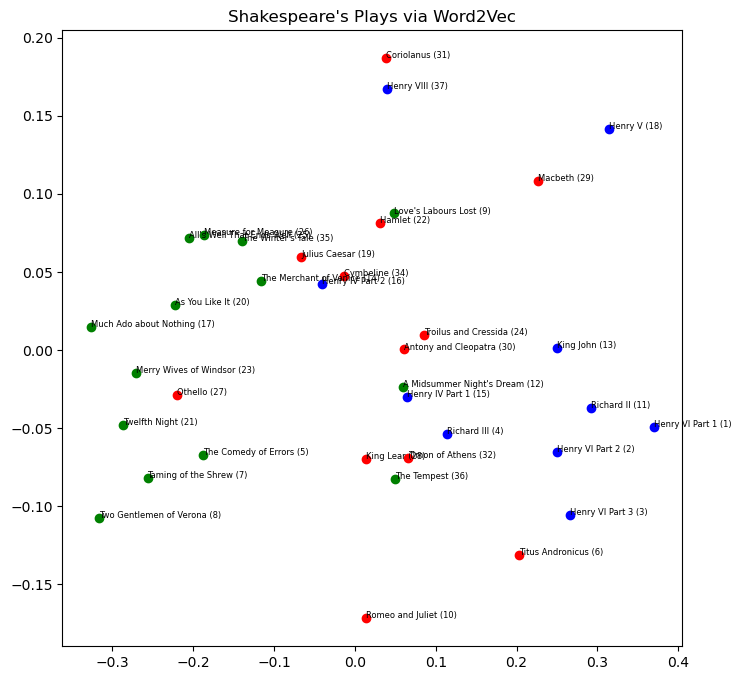

In [8]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
training_data = [sentence for group_sentences in plays_to_lines.values() for sentence in group_sentences]
w2v = Word2Vec(sentences=training_data, window=5, min_count=3, workers=4)
w2v.save("word_embeddings.model")

embeddings = w2v.wv

averaged_vectors = []
for play_title, sentences in plays_to_lines.items():
    accumulated_vector = np.zeros(w2v.vector_size)
    total_terms = 0
    for sentence in sentences:
        for term in sentence:
            if term in embeddings:
                accumulated_vector += embeddings[term]
                total_terms += 1
    if total_terms:
        accumulated_vector /= total_terms
    averaged_vectors.append(accumulated_vector)

matrix_representation = np.vstack(averaged_vectors);reduced_data = PCA(n_components=2).fit_transform(matrix_representation)

plt.figure(figsize=(8, 8))
for idx, (horizontal, vertical) in enumerate(reduced_data):
    plt.scatter(horizontal, vertical, color=color_map[genres[idx]])
    plt.annotate(f"{play_attributes_array[idx, 0]} ({play_order[idx]})", (horizontal, vertical), fontsize=6)

plt.title("Shakespeare's Plays via Word2Vec")
plt.show()


Observations 

Hmm...again interesting and i was expecting something like this. this visualization is not as denser as the one in C. plus this is grouping based on similarities rather than jus the words . so each play might be similar to each other based on words they use.

## Problem Two: Classifying Text with a Feed-Forward Neural Network (50 pts)


In this problem, you must create a FFNN in Pytorch to classify emails from the Enron dataset as to whether they
are spam or not spam ("ham"). For this problem, we will use `Glove` pretrained embeddings. The dataset
and the embeddings are in the following location:

https://drive.google.com/drive/folders/1cHR4VJuuN2tEpSkT3bOaGkOJrvIV-lSR?usp=sharing

(You can also download the embeddings yourself from the web; but the dataset is one created
just for this problem.)

### Part A: Prepare the Data (10 pts)

Compute the features of the emails (the vector of 100 floats input to the NN) vector based on the average value of the word vectors that belong to the words in it.

Just like the previous problem, we compute the 'representation' of each message, i.e. the vector, by averaging word vectors; but this time, we are using [Glove word embeddings](https://nlp.stanford.edu/projects/glove/) instead. Specifically, we are using word embedding 'glove.6B.100d' to obtain word vectors of each message, as long as the word is in the 'glove.6B.100d' embedding space.

Here are the steps to follow:

1. Have a [basic idea](https://nlp.stanford.edu/pubs/glove.pdf) of how Glove provides pre-trained word embeddings (vectors).
2. Download and extract word vectors from 'glove.6B.100d'. 
3. Tokenize the messages ( `spacy` is a good choice) and compute the message vectors by averaging the vectors of words in the message. You will need to test if a word is in the model (e.g., something like ` if str(word) in glove_model ...`) and ignore any words which have no embeddings. 


### Part B: Create the DataLoader (15 pts)

Now you must separate the data set into training, validation, and testing sets, and build a 'Dataset' and 'DataLoader' for each that can feed data to train your model with Pytorch.

Use a train-validation-test split of 80%-10%-10%. You can experiment with different batch sizes, starting with 64. 



Hints:
1. Make sure `__init__` , `__len__` and `__getitem__` of the your defined dataset are implemented properly. In particular, the `__getitem__` should return the specified message vector and its label.
2. Don't compute the message vector when calling the `__getitem__` function, otherwise the training process will slow down A LOT. Calculate these in an array before creating the data loader in the next step. 
3. The data in the `.csv` is randomized, so you don't need to shuffle when doing the split. 

In [9]:
#part A

In [10]:
import spacy
import numpy as np

nlp = spacy.load('en_core_web_sm')

def load_glove_embeddings(filepath):

    with open(filepath, 'r', encoding='utf-8') as f:
        embeddings = {line.split()[0]: np.asarray(line.split()[1:], dtype='float32') for line in f}
    return embeddings

glove_model = load_glove_embeddings('glove.6B.100d.txt')

def message_to_embedding(message, embeddings):

    tokens = [token.text for token in nlp(message) if token.text in embeddings]
    vectors = [embeddings[token] for token in tokens]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

In [11]:
#partb

In [12]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Read data and generate embeddings
df = pd.read_csv('enron_spam_ham.csv')
embeddings_list = [message_to_embedding(message, glove_model) for message in df['Message']]
labels_list = df['Spam'].values

class MessageDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

dataset = MessageDataset(embeddings_list, labels_list)
train_size, val_size = int(0.8 * len(dataset)), int(0.1 * len(dataset))
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


### Part C:  Build the neural net model (25 pts)

Once the data is ready, we need to design and implement our neural network model.

The model does not need to be complicated. An example structure could be:

1. linear layer 100 x 15
2. ReLU activation layer
3. linear layer 15 x 2

But feel free to test out other possible combinations of linear layers & activation function and whether they make significant difference to the model performance later.

In order to perform "early stopping," you must keep track of the best validation score as you go through the epochs, and
save the best model generated so far; then use the model which existed when the validation score
was at a minimum to do the testing. (This could also be the model which is deployed, although we won't
worry about that.) Read about `torch.save(...)` and `torch.load(...)` to do this. 

Experiment with different batch sizes and optimizers and learning rates to get the best validation
score for the model you create with early stopping. (Try not to look *too hard* at the final accuracy!) Include your final performance charts (using `show_performance_curves`) when you submit. 

Conclude with a brief analysis (a couple of sentences is fine) relating what experiments you did,
and what choices of geometry, optimizer, learning rate, and batch size gave you the best results.
It should not be hard to get well above 90% accuracy on the final test. 

In [13]:
import torch.nn as nn

class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(100, 15)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(15, 2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [14]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FFNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

best_val_loss, epochs = float('inf'), 40
train_losses, val_losses = [], []

def run_epoch(loader, is_train=True):
    total_loss = 0.0
    model.train(is_train)
    for data, labels in loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        if is_train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * data.size(0)
    return total_loss / len(loader.dataset)

for epoch in range(epochs):
    train_losses.append(run_epoch(train_loader))
    with torch.no_grad():
        val_loss = run_epoch(val_loader, False)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_loss:.4f}')

torch.save(best_model,'best_model.pt')


Epoch 1/40, Training Loss: 0.6798, Validation Loss: 0.6467
Epoch 2/40, Training Loss: 0.6154, Validation Loss: 0.5845
Epoch 3/40, Training Loss: 0.5481, Validation Loss: 0.5191
Epoch 4/40, Training Loss: 0.4844, Validation Loss: 0.4649
Epoch 5/40, Training Loss: 0.4340, Validation Loss: 0.4232
Epoch 6/40, Training Loss: 0.3951, Validation Loss: 0.3898
Epoch 7/40, Training Loss: 0.3647, Validation Loss: 0.3638
Epoch 8/40, Training Loss: 0.3406, Validation Loss: 0.3430
Epoch 9/40, Training Loss: 0.3205, Validation Loss: 0.3239
Epoch 10/40, Training Loss: 0.3038, Validation Loss: 0.3085
Epoch 11/40, Training Loss: 0.2896, Validation Loss: 0.2950
Epoch 12/40, Training Loss: 0.2773, Validation Loss: 0.2833
Epoch 13/40, Training Loss: 0.2667, Validation Loss: 0.2731
Epoch 14/40, Training Loss: 0.2574, Validation Loss: 0.2641
Epoch 15/40, Training Loss: 0.2494, Validation Loss: 0.2563
Epoch 16/40, Training Loss: 0.2422, Validation Loss: 0.2491
Epoch 17/40, Training Loss: 0.2359, Validation Lo

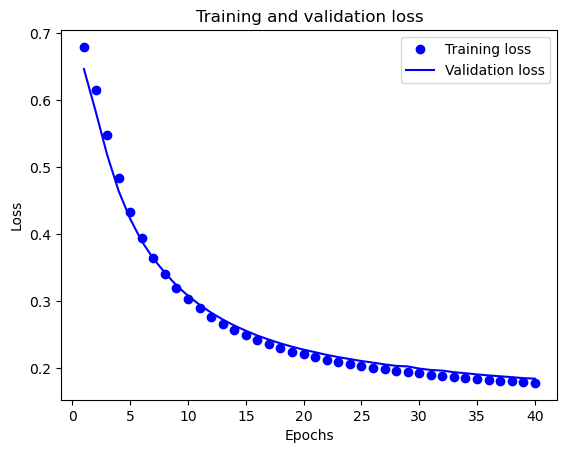

In [15]:
import matplotlib.pyplot as plt

def show_performance_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    
    plt.plot(epochs, train_losses, 'bo', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

show_performance_curves(train_losses, val_losses)


In [16]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss, correct = 0.0, 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        test_loss += criterion(outputs, labels).item() * data.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')


Test Loss: 0.1832, Test Accuracy: 93.93%


Observations/ Analysis :
    
The accuracy is pretty good. i have been testing various paramters . lets say for example lr=0.01 : it had spikes , but the accurracy was 96.63. i jumped from traditioned ADam to ADamW which is working better . i was looking for a graph with minimal or spikes . if there are spikes in the graphs then it is not good model . also the distance matters .  though i got better accuracies , i have decided to stick with this becuase from the above graph we can see that validation loss and training loss are pretty close which indicates that the model is pretty good and there are no spikes. this is a clean and efficient model